## Data Cleaning and merging dataframes

In this notebook, we'll work with `movie_basics` and `movie_ratings` tables from `'im.db'`. As well as `'tn.movie_budget.csv'`.

Before we can get going, we'll need to import the relevant packages and conncet to the database.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
import sqlite3
conn = sqlite3.connect('im.db')

In this notebook we'll focus on the `movie_basics` and `movie_ratings`.

## Compared to the Individual Tables:

### `movie_basics` Table:

In [2]:
q = """
SELECT *
FROM movie_basics
"""
pd.read_sql(q, conn).head(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


### `movie_ratings` Table:

In [3]:
q = """
SELECT *
FROM movie_ratings
"""
pd.read_sql(q, conn).head(5)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


## Displaying movie_basics Along with movie_ratings

Since we need to generate a table that includes details about ` movie_basics`  and ` movie_ratings`, we would need to take data from multiple tables in a single statement using a concise way to join the tables, the `USING` clause. Which in this case is `movie_id`. Again, this only works if the column is **identically named** for both tables.

Then we assign the result of the querry to a variable names `df`, which is a dataframe. 

In [4]:
q = """
SELECT
    movie_id, 
    primary_title,
    genres,
    averagerating,
    numvotes
FROM movie_basics
JOIN movie_ratings
    USING (movie_id)
"""
df = pd.read_sql(q, conn)

To get a concise summary of the dataframe, you can use `.info()`: 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   primary_title  73856 non-null  object 
 2   genres         73052 non-null  object 
 3   averagerating  73856 non-null  float64
 4   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 2.8+ MB


## Nan (Not a Number):
When working with datasets, it is common to have missing or `NaN (Not a Number)` values. In order to understand the extent of missing data in a dataset, you can use the `.isna()` method to identify where the `NaN` values are located. Taking the `.sum()` of the `.isna(`) method will return the total number of NaN values in the dataset broken down by column.

In [6]:
df.isna().sum()

movie_id           0
primary_title      0
genres           804
averagerating      0
numvotes           0
dtype: int64

Since the `'genre'` is a categorical data and the missing values accounts for only 1 % of our data we decided to drop the rows that contained null values using the built-in function `.dropna()`. Since we are creating a new df, a new name will be given to it as `df_nonull_genres`.

In [7]:
df_nonull_genres = df.dropna(axis = 0)

Lets print the shape of our new df. Next, display the total number of `NaN` values in the dataset broken down by column.

In [8]:
df_nonull_genres.shape

(73052, 5)

In [9]:
df_nonull_genres.isna().sum()

movie_id         0
primary_title    0
genres           0
averagerating    0
numvotes         0
dtype: int64

Since, we dont have any other missing data to deal with, lets focus on finding duplicate movie titles using `.dulpicated()` and `.value_counts()`. Lets display the total amount of dulpicated rows. Subsequently, break it down by frequency for each movie title. 

In [10]:
df_nonull_genres['primary_title'].duplicated().value_counts()

False    69248
True      3804
Name: primary_title, dtype: int64

In [11]:
df_nonull_genres[df_nonull_genres['primary_title'].duplicated()]['primary_title'].value_counts()

The Return           10
Broken                9
Lucky                 8
Homecoming            8
Together              8
                     ..
Checkmate             1
Won't Back Down       1
Political Animals     1
Dead Awake            1
Drømmeland            1
Name: primary_title, Length: 2705, dtype: int64

The df shows 69248 `non-duplicated` values. A common practice would be to handle them properly but for  scope purposes of our study, which means we are time-limited,  lets just keep them in mind. Then, lets take a look on the second dataframe.

The second `df` can be found on `'tn.movie_budget.csv'`. Now, let's get started by reading in the data  and storing it the DataFrame `movie_budget`. Afterwárds, lets preview the data.

In [12]:
movie_budget = pd.read_csv('tn.movie_budgets.csv')
movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,18-Dec-09,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,20-May-11,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,7-Jun-19,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,1-May-15,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,15-Dec-17,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


`production_budget`, `domestic_gross`, and `worldwide_gross` are strings, so we will remove the commas and dollar signs

In [13]:
movie_budget['production_budget'] = movie_budget['production_budget'].str.replace('$', '').str.replace(',', '')
movie_budget['domestic_gross'] = movie_budget['domestic_gross'].str.replace('$', '').str.replace(',', '')
movie_budget['worldwide_gross'] = movie_budget['worldwide_gross'].str.replace('$', '').str.replace(',', '')

C:\Users\mervela\AppData\Local\Temp\ipykernel_23584\3322509581.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movie_budget['production_budget'] = movie_budget['production_budget'].str.replace('$', '').str.replace(',', '')
C:\Users\mervela\AppData\Local\Temp\ipykernel_23584\3322509581.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movie_budget['domestic_gross'] = movie_budget['domestic_gross'].str.replace('$', '').str.replace(',', '')
C:\Users\mervela\AppData\Local\Temp\ipykernel_23584\3322509581.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated a

`production_budget`, `domestic_gross`, and `worldwide_gross` are still strings, so we will change them to integers to be able to perform calculations with those columns

In [14]:
movie_budget['production_budget'] = movie_budget['production_budget'].astype('int64')
movie_budget['domestic_gross'] = movie_budget['domestic_gross'].astype('int64')
movie_budget['worldwide_gross'] = movie_budget['worldwide_gross'].astype('int64')

A concise summary will be provided using `.info()`.

In [15]:
movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   int64 
 5   worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 271.2+ KB


The above summary contains also the amount of null values brake down by columns. Since we don´t have missing data to deal with, we can move into merging `movie_budget`df and `df_nonull_genres` df. 

For doing so, lets print a short preview for both Dataframes. Focus on the column names.

In [16]:
df_nonull_genres.head(2)

,movie_id,primary_title,genres,averagerating,numvotes
0,tt0063540,Sunghursh,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,"Biography,Drama",7.2,43


`movie_budget` df:

In [17]:
movie_budget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,18-Dec-09,Avatar,425000000,760507625,2776345279
1,2,20-May-11,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875


As you can see, the column which displays the movie title is different in both Dataframes. `df_nonull_genres` uses `'primary_title'`while `movie_budget` uses `'movie'`. 

We need to set them equal to use the column name as a key for merging both Dataframes into one. Will set both columns names as `'movie'`. In this case,  `df_nonull_genres` is the one selected to change its column name. 

In [18]:
df_nonull_genres.rename(columns={'primary_title' : 'movie'}, inplace = True)

C:\Users\mervela\AppData\Local\Temp\ipykernel_23584\3490391291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonull_genres.rename(columns={'primary_title' : 'movie'}, inplace = True)


Lets view the column labels of the DataFrame `df_nonull_genres`.

In [19]:
df_nonull_genres.columns

Index(['movie_id', 'movie', 'genres', 'averagerating', 'numvotes'], dtype='object')

As you see, now the column name was changed succesfully. 

## Nan (Not a Number):

The following line of code is performing a merge operation between  `df_nonull_genre`s and `movie_budget`.

The merge is performed based on a common column called `'movie'`, specified by the `on` parameter.

The type of merge used is specified by the how parameter, which in this case is set to `'left'`, meaning that all the rows from the `df_nonull_genres dataframe` will be kept and any matching rows from the `movie_budget` dataframe will be included. Any non-matching rows from the movie_budget dataframe will have null values in the resulting dataframe.

Finally, a new column called `'im_and_movie_budget'` is added to the resulting merged dataframe, indicating whether a row is present in both dataframes (i.e., 'both'), only in the left dataframe (i.e., 'left_only'), or only in the right dataframe (i.e., 'right_only'). This is specified by the `indicator` parameter.

The resulting dataframe is assigned to the variable `im_movie_budget`. Subsequently, we use `value_counts()` to return a new Series object with the count of unique values of the new column called `'im_and_movie_budget'`.

In [20]:
im_movie_budget = pd.merge(df_nonull_genres ,movie_budget, on='movie', how='left', indicator = 'im_and_movie_budget')
im_movie_budget['im_and_movie_budget'].value_counts()

left_only     70307
both           2867
right_only        0
Name: im_and_movie_budget, dtype: int64

A sample was taken from Dataframe `im_movie_budget` by selecting rows that has a string value equal to `both`on column `'im_and_movie_budget'`. That sample name is `cleaned_df`.

In [21]:
cleaned_df = im_movie_budget[im_movie_budget['im_and_movie_budget'] == 'both'] 
cleaned_df.head(4)

,movie_id,movie,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,im_and_movie_budget
16,tt0249516,Foodfight!,"Action,Animation,Comedy",1.9,8248,26.0,31-Dec-12,45000000.0,0.0,73706.0,both
36,tt0337692,On the Road,"Adventure,Drama,Romance",6.1,37886,17.0,22-Mar-13,25000000.0,720828.0,9313302.0,both
42,tt0359950,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",7.3,275300,37.0,25-Dec-13,91000000.0,58236838.0,187861183.0,both
46,tt0365907,A Walk Among the Tombstones,"Action,Crime,Drama",6.5,105116,67.0,19-Sep-14,28000000.0,26017685.0,62108587.0,both


Lets get a concise summary of the dataframe using `.info()`: 

In [22]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2867 entries, 16 to 73164
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   movie_id             2867 non-null   object  
 1   movie                2867 non-null   object  
 2   genres               2867 non-null   object  
 3   averagerating        2867 non-null   float64 
 4   numvotes             2867 non-null   int64   
 5   id                   2867 non-null   float64 
 6   release_date         2867 non-null   object  
 7   production_budget    2867 non-null   float64 
 8   domestic_gross       2867 non-null   float64 
 9   worldwide_gross      2867 non-null   float64 
 10  im_and_movie_budget  2867 non-null   category
dtypes: category(1), float64(5), int64(1), object(4)
memory usage: 249.3+ KB


floats data types
it's possible for columns with integer data types to be converted to floating point data types. This can happen if one of the dataframes has null or missing values in the column being merged.

To avoid this type conversion, you can either fill in the missing values before merging the dataframes or use the astype method to convert the column back to an integer after the merge.

In [23]:
cleaned_df['production_budget'] = cleaned_df['production_budget'].astype('int64')
cleaned_df['domestic_gross'] = cleaned_df['domestic_gross'].astype('int64')
cleaned_df['worldwide_gross'] = cleaned_df['worldwide_gross'].astype('int64')

C:\Users\mervela\AppData\Local\Temp\ipykernel_23584\2674449468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['production_budget'] = cleaned_df['production_budget'].astype('int64')
C:\Users\mervela\AppData\Local\Temp\ipykernel_23584\2674449468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['domestic_gross'] = cleaned_df['domestic_gross'].astype('int64')
C:\Users\mervela\AppData\Local\Temp\ipykernel_23584\2674449468.py:3: SettingWithCopyWarning: 
A value is trying to be set on

Added net revenue by movie

In [24]:
cleaned_df['worlwide_net_revenue'] = cleaned_df['worldwide_gross'] - cleaned_df['production_budget']
cleaned_df[['production_budget', 'worldwide_gross', 'worlwide_net_revenue']]

C:\Users\mervela\AppData\Local\Temp\ipykernel_23584\1701568743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['worlwide_net_revenue'] = cleaned_df['worldwide_gross'] - cleaned_df['production_budget']


,production_budget,worldwide_gross,worlwide_net_revenue
16,45000000,73706,-44926294
36,25000000,9313302,-15686698
42,91000000,187861183,96861183
46,28000000,62108587,34108587
47,215000000,1648854864,1433854864
...,...,...,...
72971,47000000,116773317,69773317
73096,30000000,106030660,76030660
73111,109000000,87683966,-21316034
73151,700000,1110511,410511


At this point, we are all set to begin with the Eploratory Data Analisis.

# Business Case 1: Genre based on profits

In the first business case, we need to know based on the `genres` and how much money locally and globaly they generated. So in this case we are analizing which `genres` produce more money.

## Identifying genres.

For the beginning, we need to work with the table `movie_basics` of the `im.db` data base,specifically with the columns `primary_title`, `genres` and the `tn.movie_budgets.csv` file with the columns `domestic_gross` and `worldwide_gross`.

We are creating a new dataFrame only using these columns.

In [25]:
#Creating a table with Movie Title, genres and profits
case1_df = cleaned_df.loc[:,['movie','genres','worldwide_gross']]
print(case1_df)

                                 movie                   genres  \
16                          Foodfight!  Action,Animation,Comedy   
36                         On the Road  Adventure,Drama,Romance   
42     The Secret Life of Walter Mitty   Adventure,Comedy,Drama   
46         A Walk Among the Tombstones       Action,Crime,Drama   
47                      Jurassic World  Action,Adventure,Sci-Fi   
...                                ...                      ...   
72971                            Earth              Documentary   
73096                          Sisters             Action,Drama   
73111                              Ali                    Drama   
73151                         Columbus                   Comedy   
73164                      Unstoppable              Documentary   

       worldwide_gross  
16               73706  
36             9313302  
42           187861183  
46            62108587  
47          1648854864  
...                ...  
72971        1167733

## Separating genres and counting them

Checking the DataFrame above we notice that some movie have more than 1 genre, so we need to count each one for knowing the total revenue of each genre.

So we need to serpate eache genera and put it into a new column.

In [26]:
#Dividing all of the genres
genres_cols = cleaned_df['genres'].str.split(',', expand=True)
genres_cols.columns = ['genre1','genre2','genre3']
counts1 = genres_cols['genre1'].value_counts()
counts2 = genres_cols['genre2'].value_counts()
counts3 = genres_cols['genre3'].value_counts()
total_counts = counts1.add(counts2, fill_value=0).add(counts3, fill_value=0)
total_counts

Action          630.0
Adventure       448.0
Animation       130.0
Biography       195.0
Comedy          758.0
Crime           362.0
Documentary     204.0
Drama          1491.0
Family          144.0
Fantasy         175.0
History          71.0
Horror          360.0
Music            72.0
Musical          22.0
Mystery         223.0
News              3.0
Romance         326.0
Sci-Fi          204.0
Sport            62.0
Thriller        509.0
War              39.0
Western          16.0
dtype: float64

Now, we combine the `cleaned_df` with the new three columns for each genre into a new dataFrame called `case1_vs_df`

In [27]:
#Creating a new table with number of gender, 
case1_vs_df = pd.merge(cleaned_df[['movie','domestic_gross','worldwide_gross','production_budget']], genres_cols[['genre1','genre2','genre3']], left_index = True, right_index=True)
case1_vs_df

,movie,domestic_gross,worldwide_gross,production_budget,genre1,genre2,genre3
16,Foodfight!,0,73706,45000000,Action,Animation,Comedy
36,On the Road,720828,9313302,25000000,Adventure,Drama,Romance
42,The Secret Life of Walter Mitty,58236838,187861183,91000000,Adventure,Comedy,Drama
46,A Walk Among the Tombstones,26017685,62108587,28000000,Action,Crime,Drama
47,Jurassic World,652270625,1648854864,215000000,Action,Adventure,Sci-Fi
...,...,...,...,...,...,...,...
72971,Earth,32011576,116773317,47000000,Documentary,None,None
73096,Sisters,87044645,106030660,30000000,Action,Drama,None
73111,Ali,58183966,87683966,109000000,Drama,None,None
73151,Columbus,1017107,1110511,700000,Comedy,None,None


To work with the `domestic_gross` and `worldwide_gross` is necessary to take only the numerical part, so we need to delete the "$" and "," simbols

In [28]:
#Delete the $ and ,
case1_vs_df['domestic_gross'] = case1_vs_df['domestic_gross'].replace({'\$':'',',':''},regex=True)
case1_vs_df['worldwide_gross'] = case1_vs_df['worldwide_gross'].replace({'\$':'',',':''},regex=True)
case1_vs_df['production_budget'] = case1_vs_df['production_budget'].replace({'\$':'',',':''},regex=True)
case1_vs_df

,movie,domestic_gross,worldwide_gross,production_budget,genre1,genre2,genre3
16,Foodfight!,0,73706,45000000,Action,Animation,Comedy
36,On the Road,720828,9313302,25000000,Adventure,Drama,Romance
42,The Secret Life of Walter Mitty,58236838,187861183,91000000,Adventure,Comedy,Drama
46,A Walk Among the Tombstones,26017685,62108587,28000000,Action,Crime,Drama
47,Jurassic World,652270625,1648854864,215000000,Action,Adventure,Sci-Fi
...,...,...,...,...,...,...,...
72971,Earth,32011576,116773317,47000000,Documentary,None,None
73096,Sisters,87044645,106030660,30000000,Action,Drama,None
73111,Ali,58183966,87683966,109000000,Drama,None,None
73151,Columbus,1017107,1110511,700000,Comedy,None,None


## Having all the totals

We need to convert first the data type of `domestic_gross`, `worldwide_gross` and `production_budget` columns. Then, we need to add the domestic rows values every time that a movie have some genre to have the total of all the profits and all the production budget of every genre.

In [29]:
case1_vs_df['domestic_gross'] = case1_vs_df['domestic_gross'].astype(float)
case1_vs_df['worldwide_gross'] = case1_vs_df['worldwide_gross'].astype(float)
case1_vs_df['production_budget'] = case1_vs_df['production_budget'].astype(float)

totals = {}

for index, row in case1_vs_df.iterrows():
    genres = [row['genre1'], row['genre2'], row['genre3']]
    for genre in genres:
        if genre not in totals:
            totals[genre] = {'domestic_gross': 0, 'worldwide_gross': 0, 'production_budget':0}
        totals[genre]['domestic_gross'] += row['domestic_gross']
        totals[genre]['worldwide_gross'] += row['worldwide_gross']
        totals[genre]['production_budget'] += row['production_budget']

new_df = pd.DataFrame(totals).T.reset_index().rename(columns={'index': 'genre'})
new_df['genre'] = new_df['genre'].astype('string')
new_df['genre'].fillna('Other',inplace=True)

new_df

,genre,domestic_gross,worldwide_gross,production_budget
0,Action,4.468698e+10,1.199860e+11,4.077893e+10
1,Animation,1.505947e+10,4.129402e+10,1.116779e+10
2,Comedy,3.608269e+10,8.045373e+10,2.533618e+10
3,Adventure,4.796407e+10,1.343977e+11,4.090776e+10
4,Drama,4.315093e+10,9.143296e+10,3.513053e+10
5,Romance,9.593389e+09,2.055086e+10,6.616127e+09
6,Crime,1.106037e+10,2.411083e+10,9.946593e+09
7,Sci-Fi,1.860459e+10,5.009867e+10,1.431784e+10
8,Other,6.341734e+10,1.343814e+11,4.873818e+10
9,Family,9.971529e+09,2.342681e+10,7.568903e+09


Finally, we want to select only the top 5 genres with more profits because we have a lot of genres, but we only need the most convenient genres and show them in a bar graph.

In [30]:
final_gross = new_df['worldwide_gross'] - new_df['production_budget']
new_df['total_gross'] = final_gross
new_df = new_df.sort_values(by='total_gross', ascending=False)
top_5 = new_df.head(5)
top_5

,genre,domestic_gross,worldwide_gross,production_budget,total_gross
3,Adventure,4.796407e+10,1.343977e+11,4.090776e+10,9.348997e+10
8,Other,6.341734e+10,1.343814e+11,4.873818e+10,8.564318e+10
0,Action,4.468698e+10,1.199860e+11,4.077893e+10,7.920712e+10
4,Drama,4.315093e+10,9.143296e+10,3.513053e+10,5.630243e+10
2,Comedy,3.608269e+10,8.045373e+10,2.533618e+10,5.511755e+10


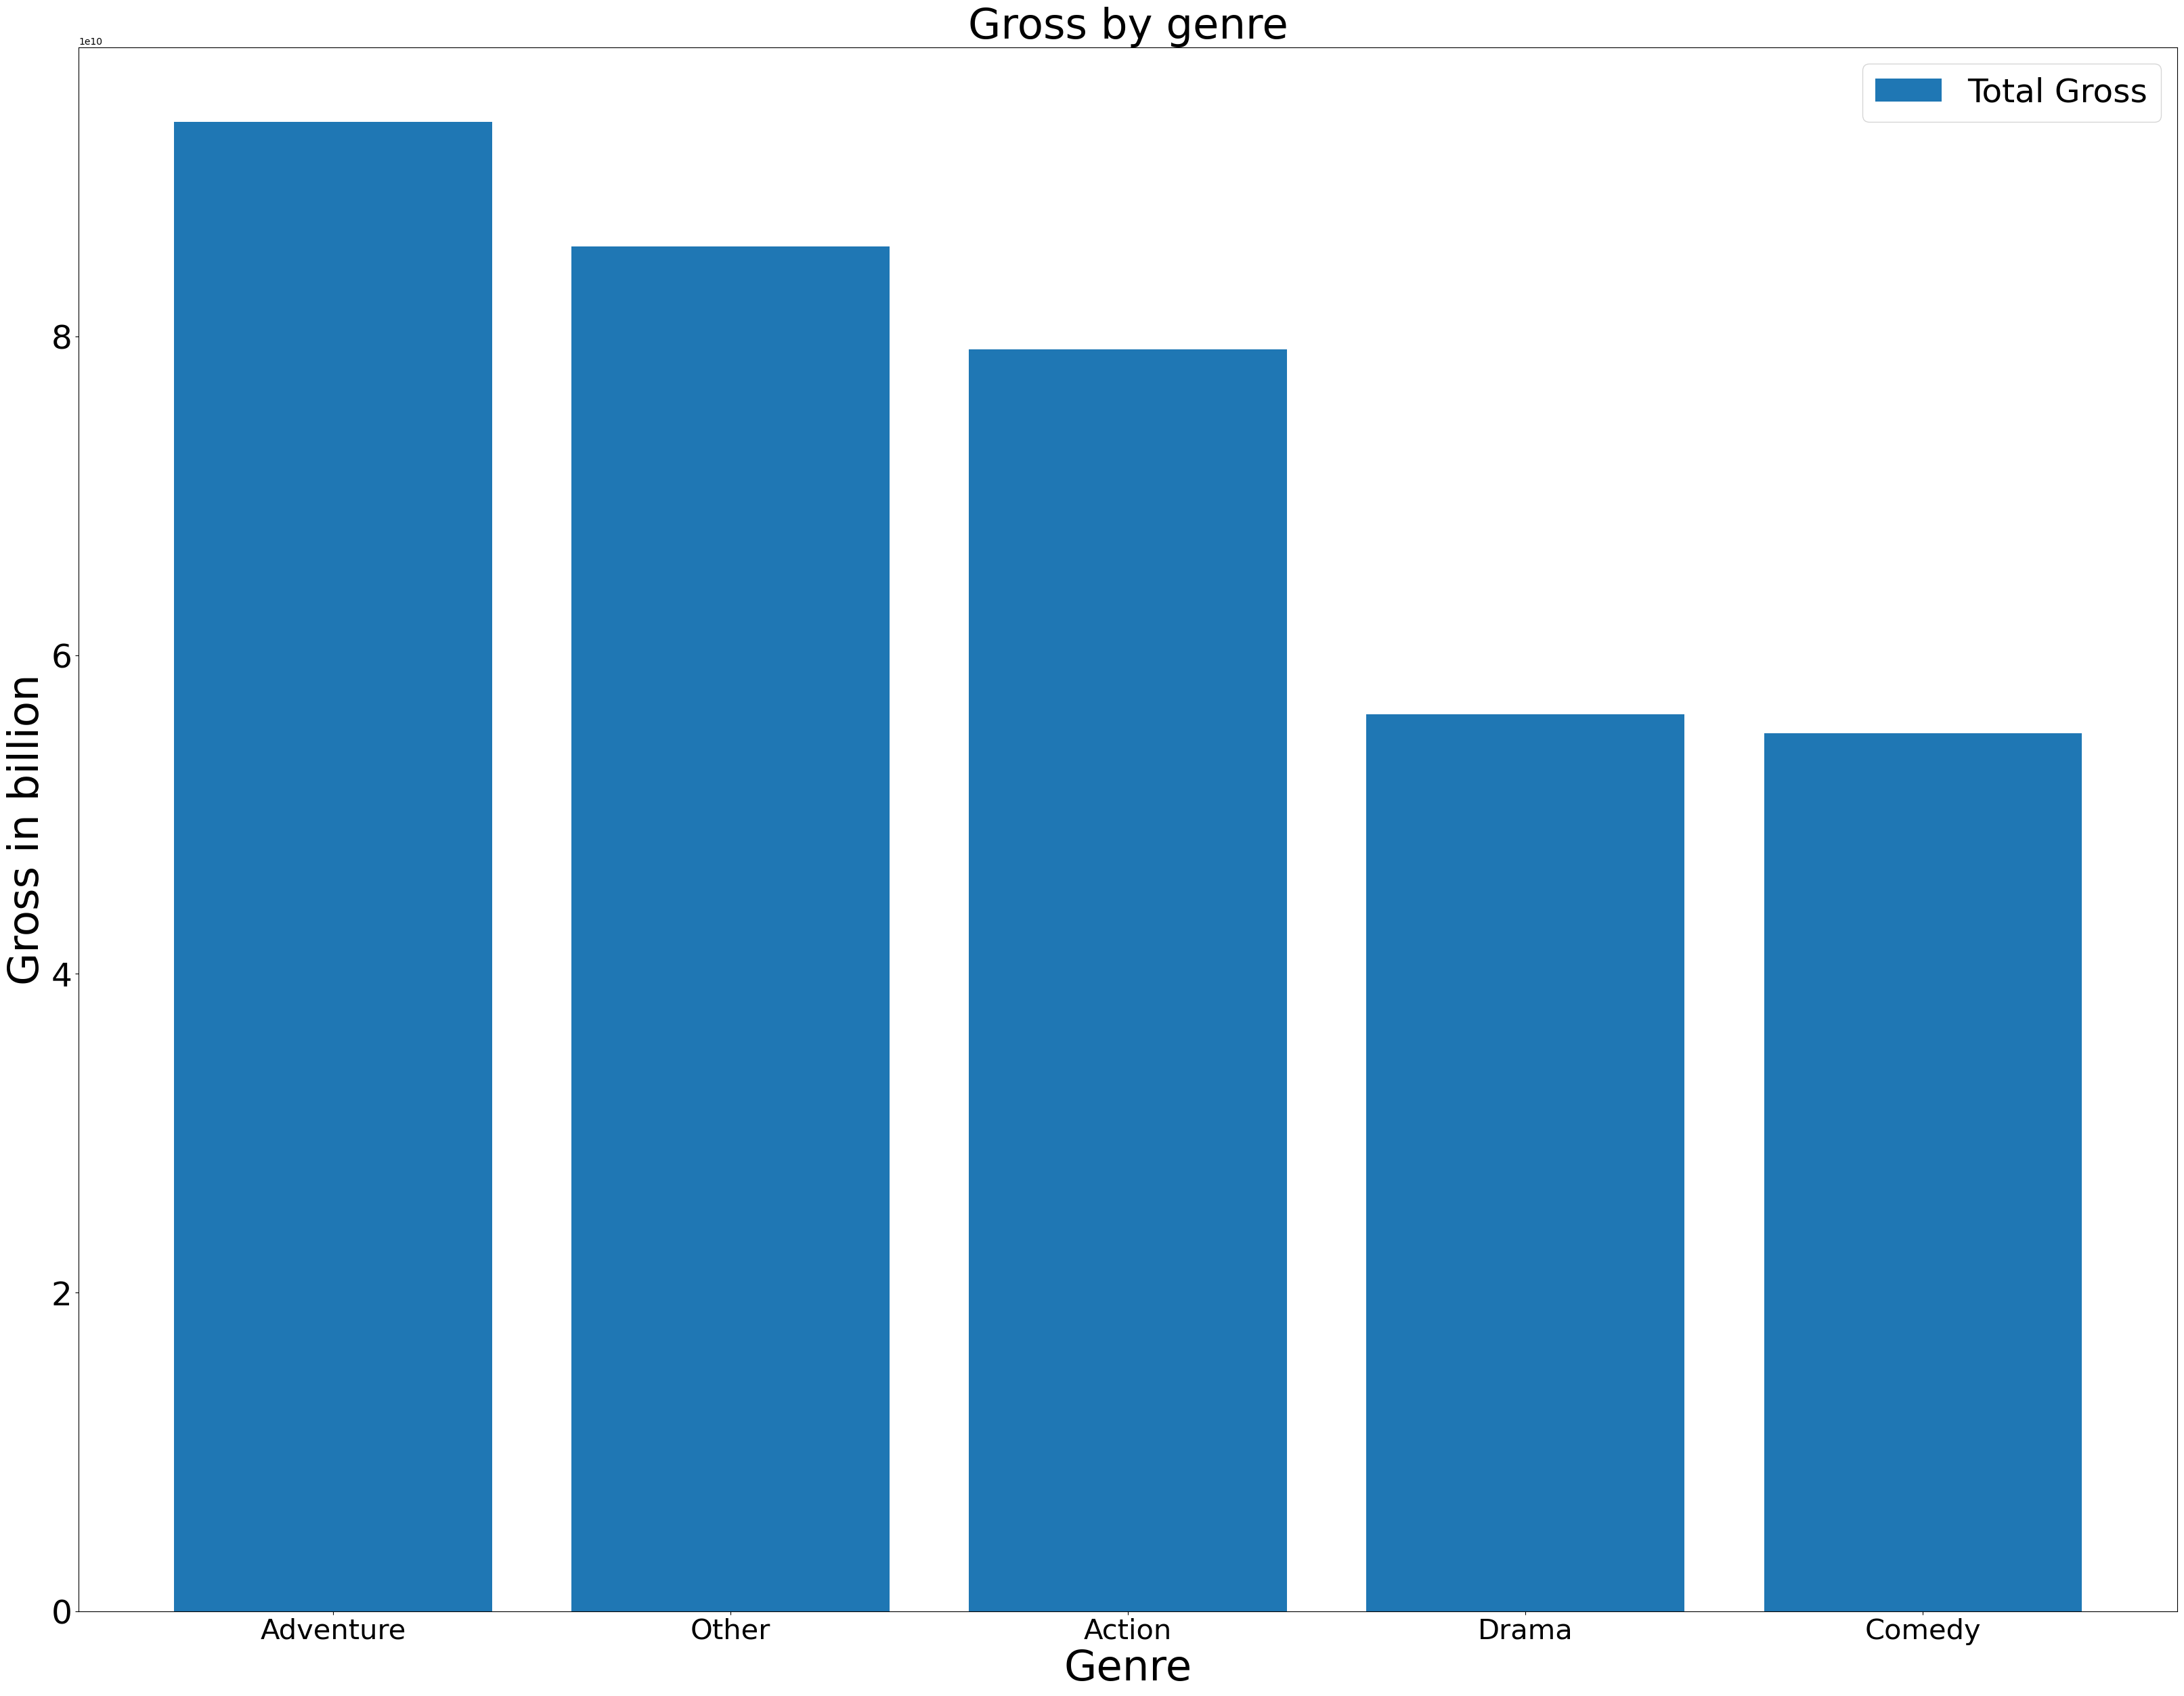

In [31]:
#Creating a bar graph for the case1_vs_df table

#Defining the columns of the x and y axis
new_df = new_df[new_df.genre !='Other']
x = top_5['genre']
y = top_5['total_gross']

#Defining the name of each bar
plt.figure(figsize=(40,30))
plt.xticks(fontsize=30)
plt.yticks(fontsize=35)
plt.bar(x,y,label='Total Gross')

#Defining name of the labels and title of the bar graph
plt.title('Gross by genre', fontsize=45)
plt.xlabel('Genre', fontsize=45)
plt.ylabel('Gross in billion', fontsize=45)

plt.legend(fontsize=35)
plt.show()


## Business Case 1: Conclusion

Checking the bar graph noticing that the genres that produce more money are `Adventure`, `Action` and `Drama`. These three genres generate more money that the other ones.

The conclusion of this business case is that if you want to create a movie that could produce a lot of money are Adventure, Action and Drama genres.

# Business Case 2: Difference in budget by genres

In this business case, we need to know based on the `genres` and how much money locally and globaly they generated. So in this case we are analizing which `genres` produce more money.

To better understand the distribution of our data lets define a function named `stats` to define the `mean`, `median`, and `standard deviation` of a given column of the dataframe

In [32]:
def stats(column):
    """
    This function takes the name of a column as inputs, and returns its mean, median and standard
    deviation. 
    
    Args: 
        column_name (str): The name of the column to get their stats. 
        
    Returns: 
        pandas.DataFrame: A new DataFrame with the specified column sorted in descending order. 
    """
    mean = cleaned_df[column].mean()
    median = cleaned_df[column].median()
    std = cleaned_df[column].std()
    return print(f' Mean:{mean}\n Median:{median}\n Std:{std}\n')

We will produce a histogram for `averagerating`

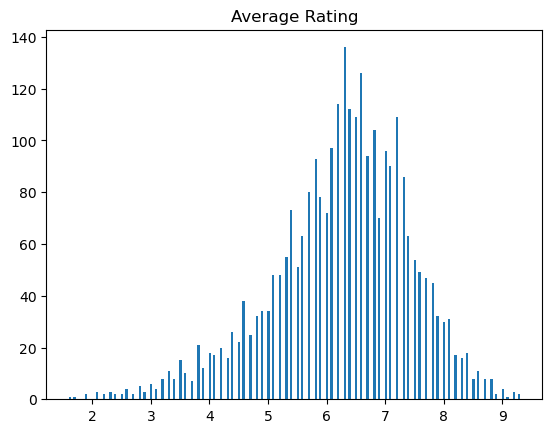

In [33]:
fig, ax = plt.subplots()
plt.hist(cleaned_df["averagerating"], bins=200)
ax.set_title("Average Rating");

We will produce the `stats` function for `averagerating`

In [34]:
stats('averagerating')

 Mean:6.249110568538549
 Median:6.4
 Std:1.1859530886691918



We will produce a histogram for `numvotes`

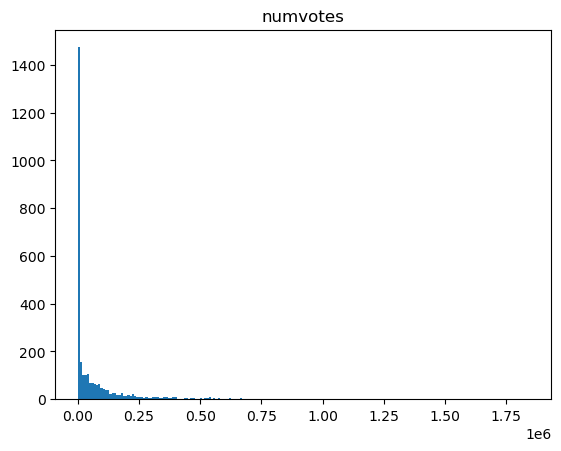

In [35]:
fig, ax = plt.subplots()
plt.hist(cleaned_df["numvotes"], bins=200)
ax.set_title("numvotes");

We will produce the `stats` function for `numvotes`

In [36]:
stats('numvotes')

 Mean:66465.27659574468
 Median:7999.0
 Std:134449.32806695305



We will produce a histogram for `production_budget`

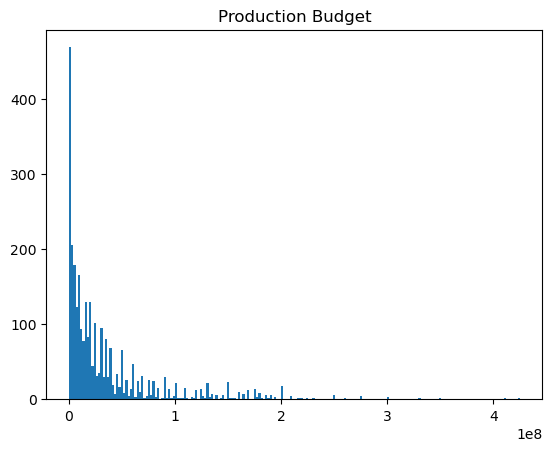

In [37]:
fig, ax = plt.subplots()
plt.hist(cleaned_df["production_budget"], bins=200)
ax.set_title("Production Budget");

We will produce the `stats` function for `production_budget`

In [38]:
stats('production_budget')

 Mean:34287085.19637252
 Median:17000000.0
 Std:47672750.903373405



We will produce a histogram for `domestic_gross`

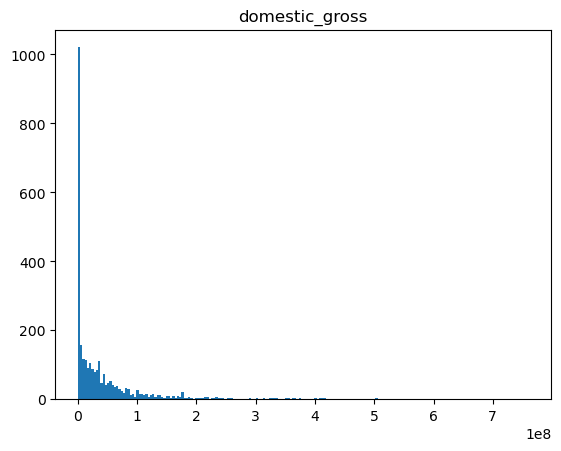

In [39]:
fig, ax = plt.subplots()
plt.hist(cleaned_df["domestic_gross"], bins=200)
ax.set_title("domestic_gross");

We will produce the `stats` function for `domestic_gross`

In [40]:
stats('domestic_gross')

 Mean:43015135.7603767
 Median:16376066.0
 Std:74609315.36676295



We will produce a histogram for `worlwide_net_revenue`

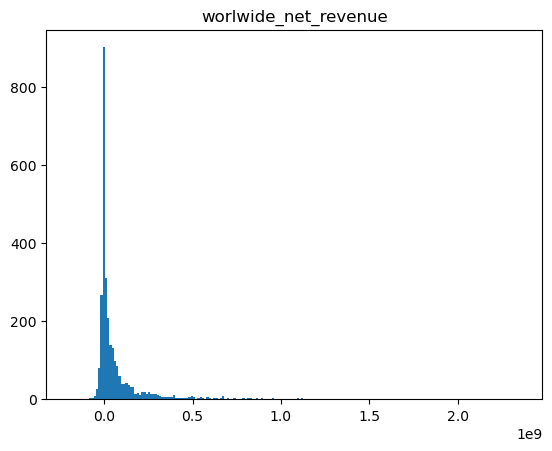

In [41]:
fig, ax = plt.subplots()
plt.hist(cleaned_df["worlwide_net_revenue"], bins=200)
ax.set_title("worlwide_net_revenue");

We will produce the `stats` function for `worlwide_net_revenue`

In [42]:
stats('worlwide_net_revenue')

 Mean:68593345.74363446
 Median:9596747.0
 Std:169464167.71571285



Our goal for this business insight is to determine two 

In [43]:
b2_cut_cleaned_df = cleaned_df[[ 'movie', 'genres', 'production_budget', 'worldwide_gross', 'worlwide_net_revenue']]
b2_cut_cleaned_df.head(3)

,movie,genres,production_budget,worldwide_gross,worlwide_net_revenue
16,Foodfight!,"Action,Animation,Comedy",45000000,73706,-44926294
36,On the Road,"Adventure,Drama,Romance",25000000,9313302,-15686698
42,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",91000000,187861183,96861183


In [44]:
# split values by commas from column genres and explode the column
b2_explode_cleaned_df = b2_cut_cleaned_df.assign(by_genre=b2_cut_cleaned_df['genres'].str.split(',')).explode('by_genre')
b2_explode_cleaned_df.head(6)

,movie,genres,production_budget,worldwide_gross,worlwide_net_revenue,by_genre
16,Foodfight!,"Action,Animation,Comedy",45000000,73706,-44926294,Action
16,Foodfight!,"Action,Animation,Comedy",45000000,73706,-44926294,Animation
16,Foodfight!,"Action,Animation,Comedy",45000000,73706,-44926294,Comedy
36,On the Road,"Adventure,Drama,Romance",25000000,9313302,-15686698,Adventure
36,On the Road,"Adventure,Drama,Romance",25000000,9313302,-15686698,Drama
36,On the Road,"Adventure,Drama,Romance",25000000,9313302,-15686698,Romance


In [45]:
b2_explode_cleaned_df['by_genre'].value_counts()

Drama          1491
Comedy          758
Action          630
Thriller        509
Adventure       448
Crime           362
Horror          360
Romance         326
Mystery         223
Sci-Fi          204
Documentary     204
Biography       195
Fantasy         175
Family          144
Animation       130
Music            72
History          71
Sport            62
War              39
Musical          22
Western          16
News              3
Name: by_genre, dtype: int64

In [46]:
b2_grouped = b2_explode_cleaned_df.groupby('by_genre')['worlwide_net_revenue'].sum().sort_values(ascending=False)
print(b2_grouped)

by_genre
Adventure      93489973689
Action         79207115558
Drama          56302432470
Comedy         55117548371
Sci-Fi         35780820714
Animation      30126228651
Thriller       27162886694
Fantasy        25537626270
Horror         16577824138
Family         15857910805
Crime          14164236303
Romance        13934733964
Mystery        10880591305
Biography       9136955887
Documentary     7139958060
Music           3438331159
Sport           3345963636
Musical         3042788841
History         2782691510
War              759431896
Western          481894392
News              60246231
Name: worlwide_net_revenue, dtype: int64


We may be asked to understand 
It is importantto understand if all the movie genres requires the same amount of budget, and by creating the box plots 
it clearly shows that dependin

In [47]:
b2_corr_table = b2_explode_cleaned_df.groupby('by_genre')[['production_budget', 'worlwide_net_revenue']].corr().iloc[0::2,-1].sort_values(ascending=False)
print(b2_corr_table)

by_genre                      
Musical      production_budget    0.777266
Sport        production_budget    0.723071
Horror       production_budget    0.709057
Sci-Fi       production_budget    0.696818
War          production_budget    0.670615
Crime        production_budget    0.662254
Action       production_budget    0.652634
Comedy       production_budget    0.629934
Family       production_budget    0.622715
Thriller     production_budget    0.619707
Fantasy      production_budget    0.610466
Adventure    production_budget    0.600707
News         production_budget    0.590920
Animation    production_budget    0.584015
History      production_budget    0.567559
Romance      production_budget    0.550052
Biography    production_budget    0.506719
Drama        production_budget    0.489720
Documentary  production_budget    0.488532
Music        production_budget    0.472445
Mystery      production_budget    0.349756
Western      production_budget    0.155151
Name: worlwide_net_reve

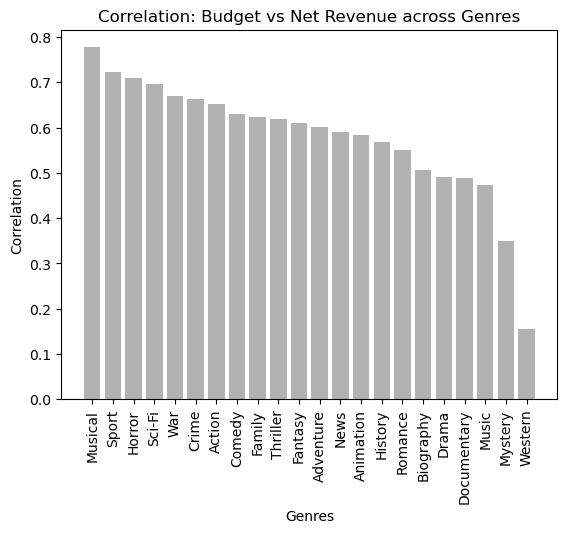

In [48]:
# Agrega aquí tu lista de nombres de películas
b3_genres_list = [genre[0] for genre in b2_corr_table.index]
b3_corre_list = list(b2_corr_table.values)

plt.bar(b3_genres_list, b3_corre_list, alpha = 0.60, color = 'grey')
plt.xlabel('Genres')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.title('Correlation: Budget vs Net Revenue across Genres')
plt.savefig('plot_corre.png', dpi=300, bbox_inches='tight')
plt.show();

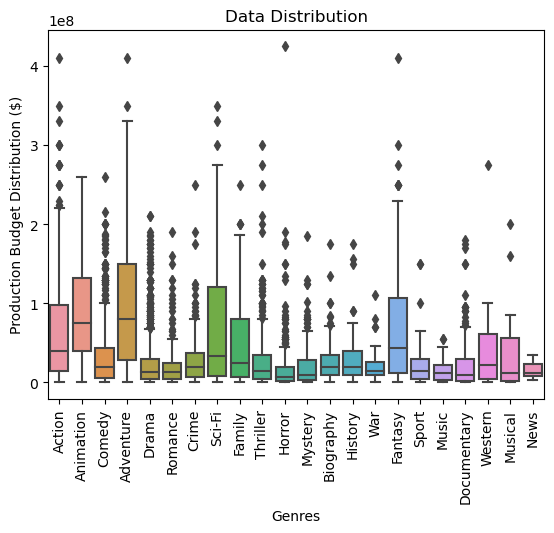

In [49]:
box_plot = sns.boxplot(x='by_genre', y='production_budget', data = b2_explode_cleaned_df)
plt.title('Data Distribution')
box_plot.set_xlabel('Genres')
box_plot.set_ylabel('Production Budget Distribution ($)')
plt.xticks(rotation=90);
plt.savefig('box_plot.png', dpi=400, bbox_inches='tight')

# Business Case #3: Release Date(Season/Month) And Correlation With Popularity/Profit

We are to Count Total Number of Movies released per Season

In [50]:
#Count total movies in each season
seasons = {'Spring': ['Mar', 'Apr', 'May'], 'Summer': ['Jun', 'Jul', 'Aug'], 'Fall': ['Sep', 'Oct', 'Nov'], 'Winter': ['Dec', 'Jan', 'Feb']}

cleaned_df['release_date']

season_dict = {'Spring':0,'Summer':0,'Fall':0,'Winter':0,}

#function to return season
def get_season(x):
    for key,val in seasons.items():
        if x in val:
            return key

#function to add movies product by season   NOTE: CHANGE 0->1 AND SPLIT BY '-'
def season_count():
    for i in cleaned_df['release_date']:
        x = i.split('-')
        key = get_season(x[1])
        season_dict[key]+=1
    return season_dict
season_count()

{'Spring': 673, 'Summer': 682, 'Fall': 751, 'Winter': 761}

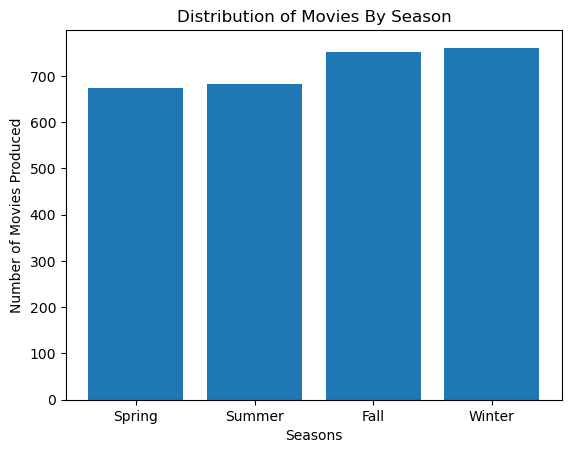

In [51]:
#Bar Chart
fig, ax = plt.subplots()

ax.bar(season_dict.keys(),season_dict.values())
ax.set_xlabel('Seasons')
ax.set_ylabel('Number of Movies Produced')
ax.set_title('Distribution of Movies By Season')

plt.savefig("figure.png")

We can see from the result that Fall-Winter has the most movie released 

We will now Count the VoteCount Popularity Between Each Season

In [52]:
#Count of Popularity between each season

cleaned_df['numvotes']

popularity_dict={'Spring':0,'Summer':0,'Fall':0,'Winter':0,}

length = cleaned_df.shape[0]

def popularity_count():
    for i in cleaned_df.itertuples():
        numvote= i[5]
        x=i[7].split('-')
        y=get_season(x[1])
        popularity_dict[y]+=numvote
    return popularity_dict

popularity_count()

{'Spring': 46994534, 'Summer': 50685780, 'Fall': 53826543, 'Winter': 39049091}

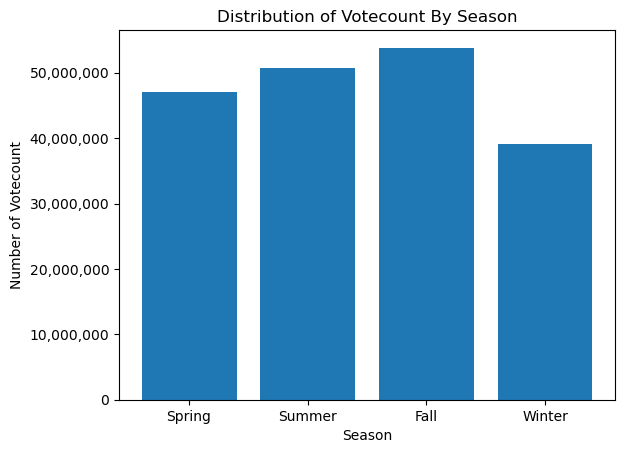

In [53]:
#Bar Chart
import matplotlib as mpl
fig, ax = plt.subplots()

ax.bar(popularity_dict.keys(),popularity_dict.values())
ax.set_xlabel('Season')
ax.set_ylabel('Number of Votecount')
ax.set_title('Distribution of Votecount By Season')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.savefig("figure4.png")

We can see that Summer-Fall is the most popular season for movies

To find an accurate rating to number of votes for each season, we will need to perform a weighted analysis for each season

In [54]:
#Ratio of Rating to Numvotes of each season List
spring_averagerating_list=[]
summer_averagerating_list=[]
fall_averagerating_list=[]
winter_averagerating_list=[]

#average numvotes
spring_numvote_list=[]
summer_numvote_list=[]
fall_numvote_list=[]
winter_numvote_list=[]

#Average Rating of each Season List
spring_rating_list=[]
summer_rating_list=[]
fall_rating_list=[]
winter_rating_list=[]

#loops through DataFrame
for i in cleaned_df.itertuples():
    rating = i[4]
    numvotes = i[5]
    avg = rating/ numvotes *100
    x=i[7].split('-')
    y=get_season(x[1])
    if y == 'Spring':
        spring_averagerating_list.append(avg)
        spring_rating_list.append(rating)
        spring_numvote_list.append(numvotes)
    if y == 'Summer':
        summer_averagerating_list.append(avg)
        summer_rating_list.append(rating)
        summer_numvote_list.append(numvotes)
    if y == 'Fall':
        fall_averagerating_list.append(avg)
        fall_rating_list.append(rating)
        fall_numvote_list.append(numvotes)
    if y == 'Winter':
        winter_averagerating_list.append(avg)
        winter_rating_list.append(rating)
        winter_numvote_list.append(numvotes)
        
sp_mean = np.mean(spring_averagerating_list)
su_mean = np.mean(summer_averagerating_list)
f_mean = np.mean(fall_averagerating_list)
w_mean = np.mean(winter_averagerating_list)

sp_mean2 = np.mean(spring_rating_list)
su_mean2 = np.mean(summer_rating_list)
f_mean2 = np.mean(fall_rating_list)
w_mean2 = np.mean(winter_rating_list)

print("Average Spring Rating:",sp_mean2)
print("Average Summer Rating:",su_mean2)
print("Average Fall Rating:", f_mean2)
print("Average Winter Rating:", w_mean2,"\n")



Average Spring Rating: 6.238335809806834
Average Summer Rating: 6.2497067448680355
Average Fall Rating: 6.323035952063916
Average Winter Rating: 6.1851511169513795 



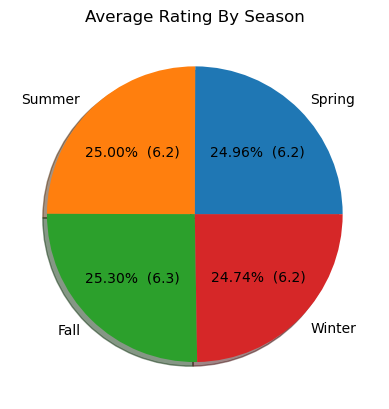

In [55]:
#Pie Chart for Average Rating
fig,ax = plt.subplots()

x = {'Spring': sp_mean, 'Summer': su_mean, 'Fall': f_mean, 'Winter': w_mean}
xx = {'Spring': sp_mean2, 'Summer': su_mean2, 'Fall': f_mean2, 'Winter': w_mean2}

#Function to format chart
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = round((pct*total/100.0),2)
        return ('{p:.2f}%  ({v:.1f})'.format(p=pct,v=val))
    return my_autopct

ax.pie(xx.values(),labels=xx.keys(),autopct = make_autopct(xx.values()), shadow=True)
ax.set_title('Average Rating By Season')

plt.show()


Based off of the pie chart, we can see that the rating for each season are pretty similar but Fall and Summer has the greatest Ratings

Within our given dataset, we can see that there may be some rating:numvotes ratio that can be inaccurate which will skew our analysis. We will now perform a weighted rating calculation to find accurate rating to number of votes

In [56]:
#weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C , where:

#* R = average for the movie (mean) = (Rating)
#* v = number of votes for the movie = (votes)
#* m = minimum votes required to be listed in the Top 250 (currently 3000)
#* C = the mean vote across the whole report (currently 6.9)

#list of each season
spring_list=[]
summer_list=[]
fall_list=[]
winter_list=[]

#median of each season
med_sp = np.median(spring_numvote_list)
med_su = np.median(summer_numvote_list)
med_f = np.median(fall_numvote_list)
med_w = np.median(winter_numvote_list)

for i in cleaned_df.itertuples():
    rating = i[4]
    numvotes = i[5]
    x=i[7].split('-')
    y=get_season(x[1])
    
    if y == 'Spring':
        wr = (numvotes / (numvotes+med_sp)) * rating + (med_sp / (numvotes + med_sp)) * sp_mean2
        spring_list.append(wr)
    elif y == 'Summer':
        wr = (numvotes / (numvotes+med_su)) * rating + (med_su / (numvotes + med_su)) * su_mean2
        summer_list.append(wr)
    elif y == 'Fall':
        wr = (numvotes / (numvotes+med_f)) * rating + (med_f / (numvotes + med_f)) * f_mean2
        fall_list.append(wr)
    elif y == 'Winter':
        wr = (numvotes / (numvotes+med_w)) * rating + (med_w / (numvotes + med_w)) * w_mean2
        winter_list.append(wr)

#average list
avg_sp_mean = np.mean(spring_list)
avg_su_mean = np.mean(summer_list)
avg_f_mean = np.mean(fall_list)
avg_w_mean= np.mean(winter_list)

print('Weighted Average Spring Rating: ',avg_sp_mean )
print('Weighted Average Summer Rating: ',avg_su_mean )
print('Weighted Average Fall Rating: ',avg_f_mean )
print('Weighted Average Winter Rating: ',avg_w_mean )

Weighted Average Spring Rating:  6.32352831735592
Weighted Average Summer Rating:  6.327367181515572
Weighted Average Fall Rating:  6.470400097919406
Weighted Average Winter Rating:  6.221610798601266


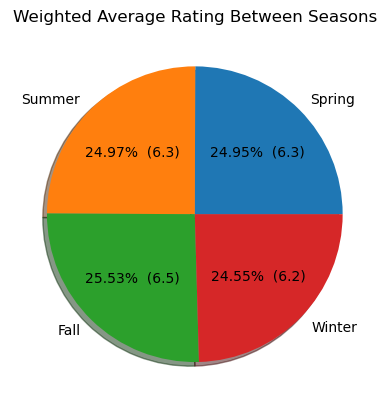

In [57]:
#Pie Chart for weighed average
xxx = {'Spring': avg_sp_mean, 'Summer': avg_su_mean, 'Fall': avg_f_mean, 'Winter': avg_w_mean}

fig3,ax3 = plt.subplots()

ax3.pie(xxx.values(),labels=xxx.keys(),autopct = make_autopct(xxx.values()), shadow=True)
ax3.set_title('Weighted Average Rating Between Seasons')

plt.show()

With the weighted rating calculations, we can see that Fall and Summer is the most popular

Correlation Between Release Month vs. Number of Votes Popularity

C:\Users\mervela\AppData\Local\Temp\ipykernel_23584\4095425253.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label)


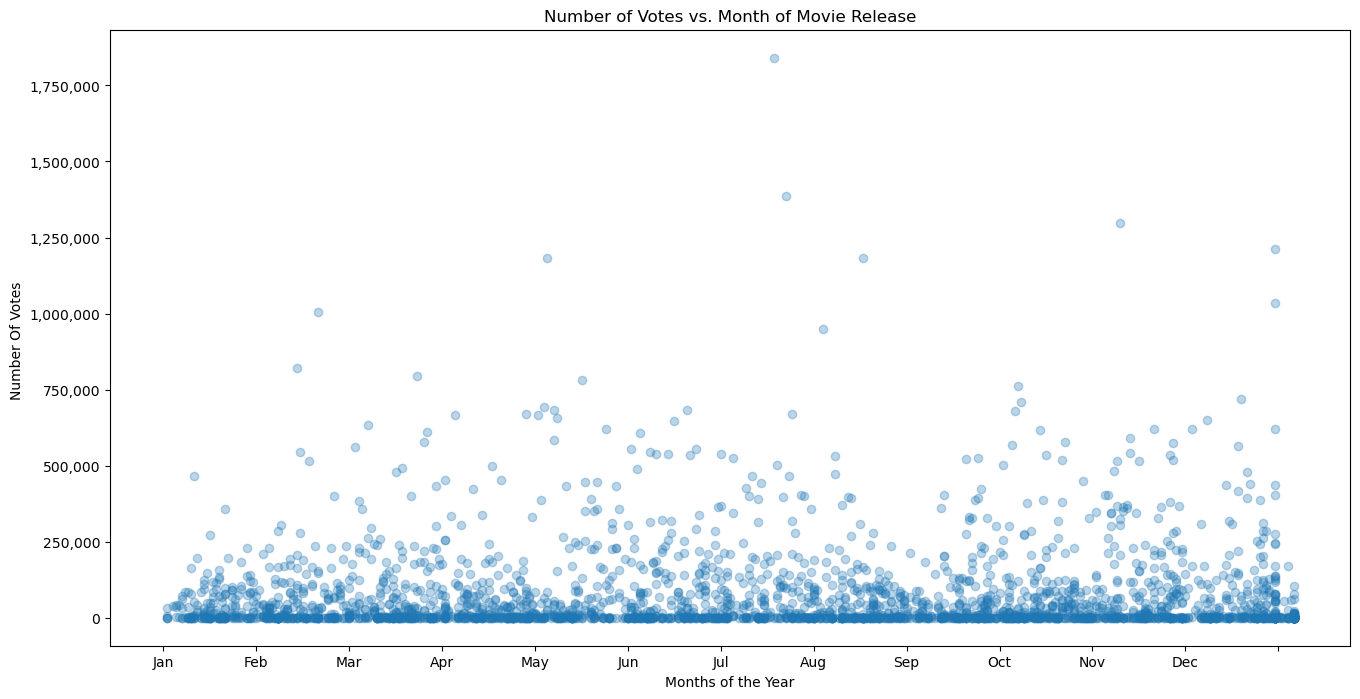

In [58]:
#correlation between release date vs. numvotes
import calendar
from datetime import datetime
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
fig, ax = plt.subplots(figsize=(16, 8))

month_list=[]
month_value = {'Jan':1,'Feb':32,'Mar': 60,'Apr':91, 'May':121, 'Jun':152, 'Jul':182, 'Aug':213,'Sep':244,"Oct":274,'Nov':305,'Dec':335}

#Convert Date to Int
for i in cleaned_df['release_date']:
        x = i.split('-')
        val = month_value[x[1]]
        y = x[0]
        month_list.append(val + int(y) - 1) 

#Plot
label = ['','Jan', 'Feb', 'Mar','Apr','May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
ax.scatter(month_list,cleaned_df['numvotes'],alpha=0.3)
ax.set_xlabel('Months of the Year')
ax.set_ylabel('Number Of Votes ')
ax.set_title('Number of Votes vs. Month of Movie Release')

ax.xaxis.set_major_locator(MultipleLocator(30))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticklabels(label)


plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()



In [59]:
The correlation between number of vote and release month, has weak correlation but the highest popularity of the movie based on our limited datset, is around Summer Time

SyntaxError: invalid syntax (204422144.py, line 1)

In [60]:
seasons = {'Spring': ['Mar','Apr','May'], 'Summer': ['Jun','Jul','Aug',], 'Fall': ['Sep','Oct','Nov'], 'Winter': ['Dec','Jan','Feb']}

test = {'Spring':0,'Summer':0,'Fall':0,'Winter':0,}
def get_season(x):
    for key,val in seasons.items():
        if x in val:
            return key
#This is for gross domestic        
for i in cleaned_df.itertuples():
    date = i[7]
    x=i[7].split('-')
    y=get_season(x[1])
    num=i[9]
    test[y]+=int(num)
print('gross domestic', test)   

gross_worldwide = {'Spring':0,'Summer':0,'Fall':0,'Winter':0,}
#This is for gross worldwide    
for i in cleaned_df.itertuples():
    date = i[7]
    x=i[7].split('-')
    y=get_season(x[1])
    num = i[10]
    gross_worldwide[y]+=int(num)
print('gross worldwide', gross_worldwide)

gross domestic {'Spring': 32267117335, 'Summer': 35185851273, 'Fall': 26847802292, 'Winter': 29023623325}
gross worldwide {'Spring': 79989060868, 'Summer': 83425075374, 'Fall': 65576756077, 'Winter': 65967303186}


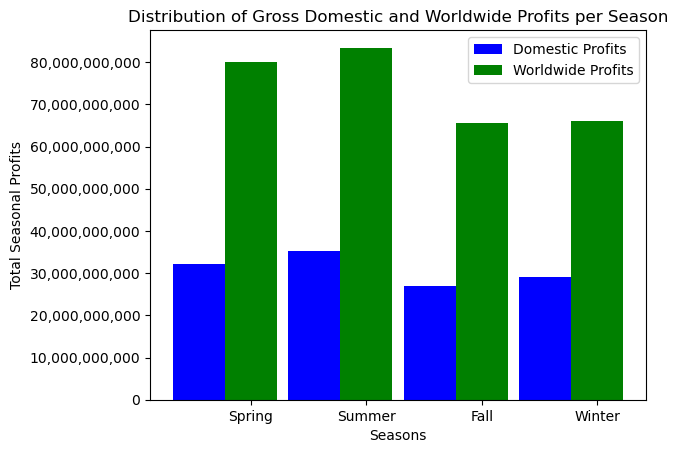

In [61]:
import matplotlib as mpl
fig, ax = plt.subplots()
X = ['Spring','Summer','Fall','Winter'] #x values manually entered

ind = np.arange(len(season_dict.keys()))
N = 2 #num of bars
width = 0.45 # the width of the bars

rects1 = ax.bar(ind,test.values(), width, color='b')
rects2 = ax.bar(ind+width,gross_worldwide.values(), width, color='g')

ax.set_xlabel('Seasons')
ax.set_ylabel('Total Seasonal Profits')
ax.set_title('Distribution of Gross Domestic and Worldwide Profits per Season')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticks(ind+width, ('Spring', 'Summer', 'Fall', 'Winter') )
ax.legend( (rects1[0], rects2[0]), ('Domestic Profits', 'Worldwide Profits') )

In [62]:
import scipy.stats as stats
from math import sqrt

print('Total profits:',gross_worldwide['Summer'] + gross_worldwide['Spring'])

summer_list = []
winter_list=[]
fall_list=[]
spring_list=[]

for i in cleaned_df.itertuples():
    x= i[7].split('-')
    key = get_season(x[1])
    num = i[9]
    if key == 'Summer':
        summer_list.append(int(num))
    if key == 'Winter':
        winter_list.append(int(num))
    if key == 'Fall':
        fall_list.append(int(num))
    if key == 'Spring':
        spring_list.append(int(num))
        
print('Sample Mean:', np.mean(summer_list) + np.mean(spring_list)) 
#print('Sample Number:', len(summer_list)) 

x_bar = np.mean(summer_list) + np.mean(spring_list) #sample mean 
n = 4 # number of seasons in a year
sigma = np.std(summer_list + winter_list + fall_list + spring_list) #sd of population
mu = (np.mean(summer_list) + np.mean(winter_list) + np.mean(fall_list) + np.mean(spring_list))/4 # Population mean 
print('Population Mean:',mu)

z = (x_bar - mu)/(sigma/(sqrt(n)))
                  
print('Z-Score:',z)

Total profits: 163414136242
Sample Mean: 99537353.92626137
Population Mean: 43356388.302691706
Z-Score: 1.5062667651495287


In [1]:
pval = 1 - stats.norm.cdf(z)
pval

NameError: name 'stats' is not defined

In [2]:
#plot of value on a standard normal distribution
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.fill_between(x=np.arange(-4,1.50,0.01),
                 y1= stats.norm.pdf(np.arange(-4,1.50,0.01)) ,
                 facecolor='blue',
                 alpha=0.35,
                 label= 'Area below z-statistic'
                 )

plt.fill_between(x=np.arange(1.50,4,0.01), 
                 y1= stats.norm.pdf(np.arange(1.50,4,0.01)) ,
                 facecolor='green',
                 alpha=0.35, 
                 label= 'Area above z-statistic')
plt.legend()
plt.title ('z-statistic = 1.50');

NameError: name 'stats' is not defined